In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from ml_logger import logger
import numpy as np
from tqdm import tqdm, trange

In [3]:
# the issue is that you are always removing edges from the graph.
def box_transitions(*size, w=0.6, r=0.03):
    """
    generate a distribution of trajectories in the -w/2, w/2 box
    :return: s, s'
    """
    s = (np.random.rand(*size) - 0.5) * w
    s_prime = s + (np.random.rand(*size) - 0.5) * r
    return s, s_prime

def corner_transitions(*size, w=0.6, r=0.03):
    """
    generate a distribution of trajectories in the bottom
    left corner, with width `w`.
    :return: s, s'
    """
    s = np.random.rand(*size) * w
    s_prime = s + (np.random.rand(*size) - 0.5) * r
    return s, s_prime

from uvpn.memory import MeshMemory

class TestArgs:
    latent_dim = 2
    plot_interval = None

In [4]:
%%bash
echo "vertices/edges 2000/24688" >> README.md
echo "vertices/edges 850/3622" >> README.md

In [ ]:
def no_drop_test():
    """Keep all of the nodes in these transitions.
    We do so by setting the graph size to |V| = 2000 for
    1000 transitions (two observations each).
    """
    s, s_prime = box_transitions(1000, TestArgs.latent_dim)
    mem = MeshMemory(None, n=2000, latent_dim=TestArgs.latent_dim, 
                     neighbor_r=0.035, neighbor_r_min=0.02)
    trajs = np.array([s, s_prime]).transpose(1, 0, 2)

    for i, traj in enumerate(tqdm(trajs)):

        mem.add_traj(traj)

        if TestArgs.plot_interval and i % TestArgs.plot_interval == 0:
            mem.plot(f"figures/mesh_{i:04d}.png", 
                     title="$\vert V \vert = 2000",
                     thin=6, show=True)

    mem.plot(f"figures/mesh_all_data.png", thin=1, show=True)

no_drop_test()

all edges:  74%|███████▍  | 19963/27068 [04:14<03:12, 36.93it/s]

all edges: 100%|██████████| 3622/3622 [00:10<00:00, 345.76it/s]


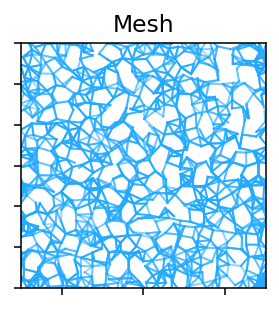

In [8]:
def uniform_test():
    """Initial test with uniform samples"""
    s, s_prime = box_transitions(10000, TestArgs.latent_dim)
    mem = MeshMemory(None, n=850, latent_dim=TestArgs.latent_dim, 
                     neighbor_r=0.035, neighbor_r_min=0.02)
    trajs = np.array([s, s_prime]).transpose(1, 0, 2)

    for i, traj in enumerate(tqdm(trajs)):

        mem.add_traj(traj)

        if TestArgs.plot_interval and i % TestArgs.plot_interval == 0:
            mem.plot(f"figures/mesh_{i:04d}.png", 
                     title="Mesh $\vert V\vert = 850$", 
                     thin=6, show=True)

    mem.plot(f"figures/mesh_all.png", thin=1, show=True)

uniform_test()

[Text(0, 0, ''), Text(0, 0, '10k'), Text(0, 0, '20k')]

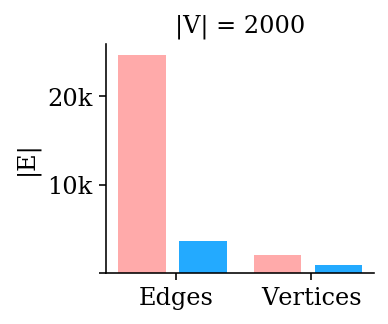

In [60]:
from uvpn_analysis.maze import stylize

x=["", "Edges", "Vertices"]
y=["", "10k", "20k"]

plt.figure(figsize=(2.4, 2.1))
# plt.subplot(121)
plt.bar(x=[-0.5, 1.5], height=[24688, 2000], width=0.7, color="#ffaaaa")
plt.bar(x=[0.4, 2.4], height=[3622, 850], width=0.7, color="#23aaff")
plt.title("|V| = 2000")
plt.ylabel("|E|")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# ax.set_xticks(ind+width)
plt.gca().set_xticklabels(x)
plt.gca().set_yticklabels(y)
# ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

# plt.subplot(122)
# plt.bar(x=["all", "fixed"], height=[2000, 850], width=0.8, color="gray")
# plt.title("|V|")
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

Clean up the plot on the top, so that the vertices uses a different y-axis.

In [ ]:
def dynamic_test(n=400, after=50, step=1, taper=100, show=False):

    mem = MeshMemory(None, n=300, latent_dim=TestArgs.latent_dim,
                     neighbor_r=0.035, neighbor_r_min=0.02)

    for i in range(after, n + taper + 1, step):
        s, s_prime = corner_transitions(5, TestArgs.latent_dim, w=0.3 * np.min([i / n, 1]))
        # trajs = np.array([s, s_prime]).transpose(1, 0, 2)
        mem.add_traj(s)
        # if i >= after and i % interval == 0:
        mem.pressure_release(threshold=500)

        mem.plot(f"figures/dynamic/mesh_{i:04d}.png", xlim=(0, 0.3), ylim=(0, 0.3),
                 show=show, thin=1, maxlen=4000 * i // n)
        
dynamic_test()

In [13]:
%%bash
pwd

/Users/ge/fair/plan2vec/uvpn/memory/notebooks


In [19]:
%%bash
cd ../figures/dynamic && \
yes | ffmpeg -r 60 -f image2 -s 630x720 -start_number 0 -i mesh_%04d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p test.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   